In [1]:
import numpy as np
import torch
import scipy
#import sympy as sp
import time

import sys
sys.path.insert(1, './PSM_V1')
from sobolev import Sobolev
from solver import Solver
from utils import matmul
from diffeomorphisms import hyper_rect
import surrogates
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [3]:
# Tests
# a=-1.0, b=1.0, q=3, sob_2d(deg=30), sob_1d(deg=100), model(n=30, p=np.inf), s=[0,-1], optimizer:LBFGS

### 2D Poisson Equation
Let $\Omega = (-1 , 1)^2, A, C, \omega, \beta \in \mathbb{R}$:
$${\large\begin{cases}
        \Delta u + f = 0, (x,y) \in \Omega\\
        u = g, (x,y) \in \partial \Omega
    \end{cases}}$$
with:
$$
    {\large f(x,y) = 2\lambda^2 cos(\lambda x) sin(\lambda y)}\\
    {\large g(x,y) = cos(\lambda x) sin(\lambda y)}\\
    {\large \lambda = 2 \pi q}
$$

In [4]:
rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])

q = 1/2
lam = 2*np.pi*q

def f(x,y):
    return 2*lam**2*np.cos(lam*x)*np.sin(lam*y)

In [5]:
# Sobolev Cubature
diffeo_2d = hyper_rect(*rect)
diffeo_1d_0 = hyper_rect(rect[0])
diffeo_1d_1 = hyper_rect(rect[1])

sob_2d = Sobolev(deg=25, dim=2, diffeo=diffeo_2d)
sob_1d_0 = Sobolev(deg=100, diffeo=diffeo_1d_0)
sob_1d_1 = Sobolev(deg=100, diffeo=diffeo_1d_1)

dx2, dy2 = torch.tensor(sob_2d.diff.diffs(np.array([[2,0],[0,2]])))

In [6]:
dx2.shape

torch.Size([676, 676])

In [7]:
# Surrogate Model
model = surrogates.Polynomial(
    n=25,
    p=np.inf,
    dim=2,
    scale=[np.max(np.abs(rect[0])), np.max(np.abs(rect[1]))])
model.set_weights_val(0.0)
model_deg = model.get_deg()

In [8]:
class Beta(torch.nn.Module):

    def __init__(self, param_size =1):
        super(Beta, self).__init__()
        self.param_size = param_size
        self.fc_In = torch.nn.Linear(1,1, bias =  False)

    def set_weights(self, val):
        with torch.no_grad():
            self.fc_In.weight.copy_(val*torch.ones_like(self.fc_In.weight))

    def forward(self, x):
        out = self.fc_In.weight*torch.ones_like(x)
        return out

In [9]:
# Surrogate Model
lam_t = Beta()
lam_t(torch.tensor([0]))[0][0]

tensor(-0.6806, grad_fn=<SelectBackward0>)

### Ground Truth

In [10]:
def gt(x,y):
    return np.cos(lam*x)*np.sin(lam*y)

### Gradient Flow

In [11]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# For that use:
# -> sob.set_s(s)
# -> sob.metric(rev=False/True, weak=False/True)

In [12]:
# Sobolev Order
sob_2d.set_s(0)

In [13]:
# Data
_, xs_bndr_0 = sob_1d_0.get_xs()
_, xs_bndr_1 = sob_1d_1.get_xs()
xs_plt, xs = sob_2d.get_xs()
leja_grid_2d = sob_2d.get_leja_grid()

dmn = model.data_axes(xs).T
bndr_0 = model.data_axes([xs_bndr_0[0], rect[1][0:1]]).T
bndr_0 = torch.cat((bndr_0, model.data_axes([xs_bndr_0[0], rect[1][1:2]]).T))
bndr_1 =  model.data_axes([[rect[0][0:1]], xs_bndr_1[0]]).T
bndr_1 = torch.cat((bndr_1, model.data_axes([rect[0][1:2], xs_bndr_1[0]]).T))

_x = leja_grid_2d[:,0]
_y = leja_grid_2d[:,1]

u_bndr_0 = torch.tensor(gt(xs_bndr_0[0], rect[1].reshape(-1,1)).reshape(-1))
u_bndr_1 = torch.tensor(gt(rect[0].reshape(-1,1), xs_bndr_1[0]).reshape(-1))

fXY = f(_x,_y)
gt_ = gt(_x, _y)
# Sobolev Metrics
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

# Formulation
K = dx2+dy2
crit_rec = lambda u: torch.sum(((u-gt_)*w)**2)
eq = lambda u, lam: matmul(K, u)+lam*gt_
crit_dmn = lambda u, lam: sob_2d.loss(eq(u, lam), weak=True)
crit_bndr_0 = lambda u: sob_1d_0.l2_loss(u-u_bndr_0)
crit_bndr_1 = lambda u: sob_1d_1.l2_loss(u-u_bndr_1)
grad_dmn = lambda u: 2*matmul(K.T, metric_2d(eq(u)))
grad_bndr_0 = lambda u: 2*metric_1d_0(u-u_bndr_0)
grad_bndr_1 = lambda u: 2*metric_1d_1(u-u_bndr_1)

# Testing
test_xs = [np.linspace(*rect[0], 249),np.linspace(*rect[1], 249)]
data = model.data_axes(test_xs).T

/home/suarez08/PhD_PINNs/PIPS_framework/surrogates.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[i] = np.array(outer_arr(np.array([data_xs[(d-1)-__][_[(d-1)-__]] for __ in range(d)])))


In [14]:
solver = Solver(
    dmns=[dmn],
    crits=[crit_rec],
    model=model,
    test_axes=test_xs,
    gt=gt,
    data=data)

In [15]:
# accuracy test of formulation
crit_dmn(gt(_x, _y), 2*lam**2)

tensor(8.1626e-20)

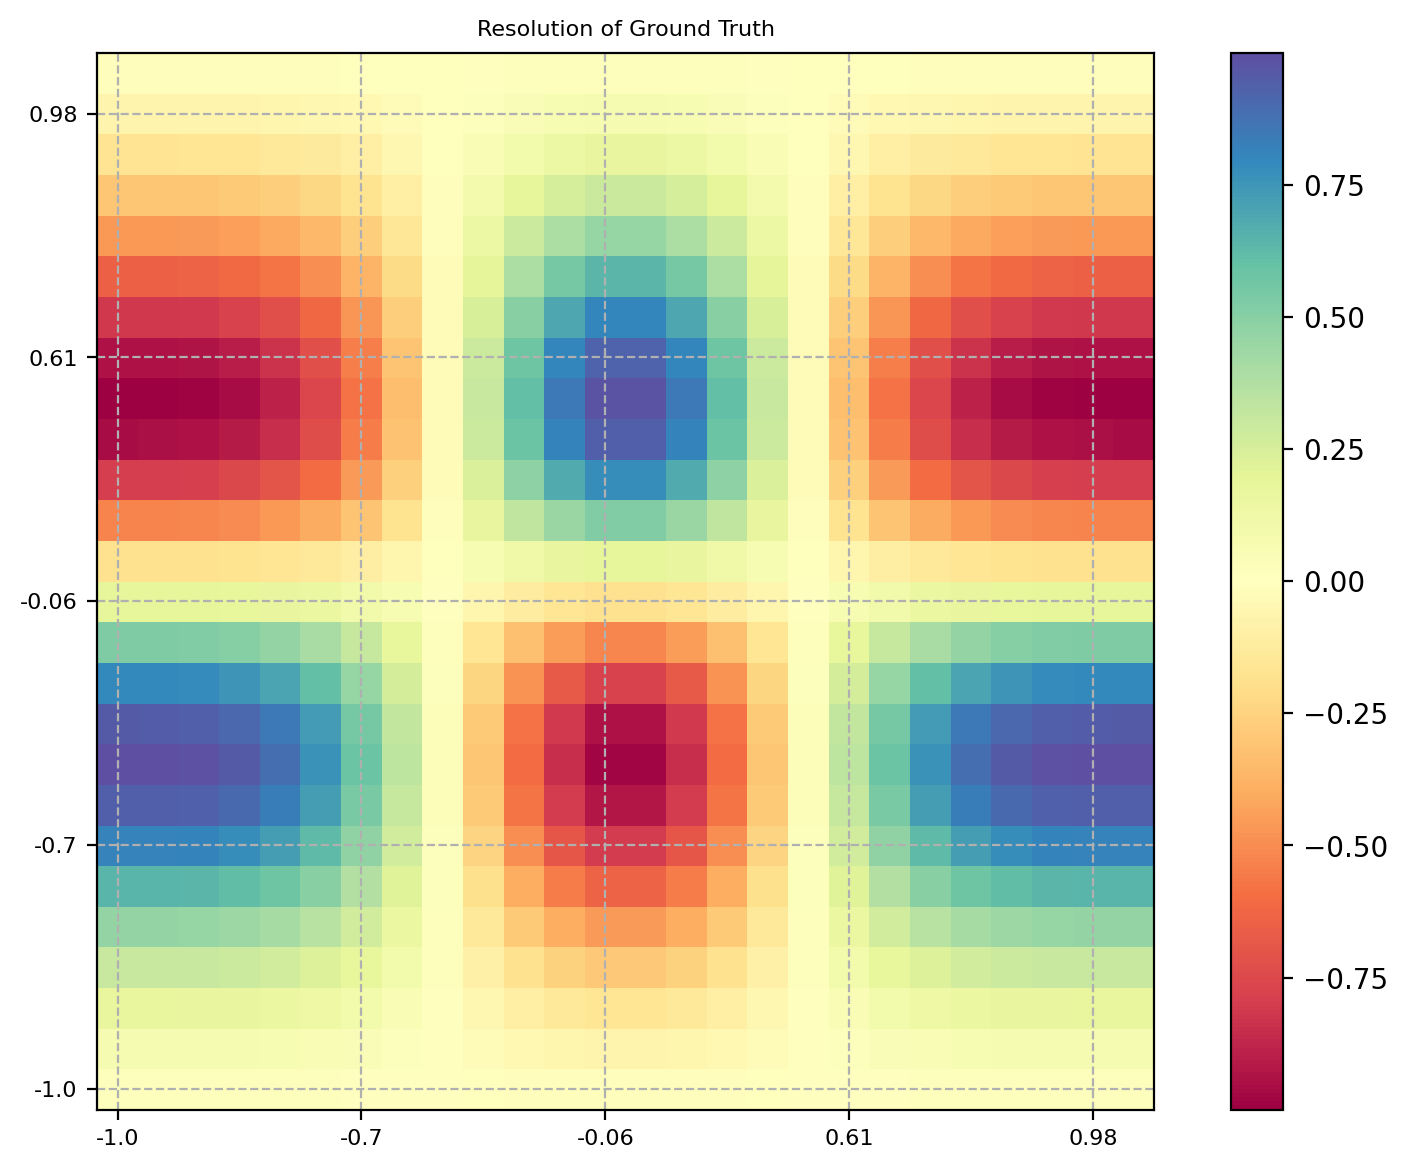

In [16]:
grid_2d = sob_2d.get_grid()
fn = "gt_resolution_poisson_eq_2d"
solver.plot2d(gt(grid_2d[:,0], grid_2d[:,1]).reshape(len(xs_plt[0]),len(xs_plt[1])), xs_plt[0], xs_plt[1], title="Resolution of Ground Truth")#, file_name=fn)

In [17]:
w = sob_2d.get_leja_weights()

## Implict Euler Gradient Flow Solution

In [18]:
W= torch.diag(w)
model.set_weights_val(0.0)
lam_t.set_weights(torch.tensor([1.0]))

In [19]:
K = torch.matmul(dx2+dy2,dmn)
gradLr = 2*torch.matmul(dmn.T,torch.matmul(W,dmn))
rhs_r = 2*torch.matmul(dmn.T,gt_*w)
lam_p = lam_t(torch.tensor([0]))[0][0]
rhs_p = -2*torch.matmul(K.T,lam_p*gt_*w)
gradLp = 2*torch.matmul(K.T,torch.matmul(W,K))
proj_grd = gradLp+gradLr#torch.sum(gradLr+gradLp)
grad_inv = (torch.eye(len(dmn.T))+proj_grd).inverse()

In [20]:
w_0 = torch.zeros(len(list(model.parameters())[0][0]))
w_t = w_0
lam_p = lam_t(torch.tensor([0]))[0][0]
start = time.time()
for k in range(1000):
    #lam_p = 2*lam**2
    rhs_p = -2*torch.matmul(K.T,lam_p*gt_*w)
    w_t = torch.matmul(grad_inv,(w_t+rhs_r+rhs_p))
    lam_p = 1/(1+torch.sum(2*(torch.matmul(K,w_t)+lam_p*gt_)*w*gt_))*lam_p
elapsed_time = time.time() - start
print('CPU time =', elapsed_time)

CPU time = 0.5178914070129395


In [21]:
model.set_weights(torch.tensor(w_t))

/tmp/ipykernel_133087/595999688.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model.set_weights(torch.tensor(w_t))


pred rel. linf-error = 3.467523e-09
pred rel. l2-error = 7.265777e-10


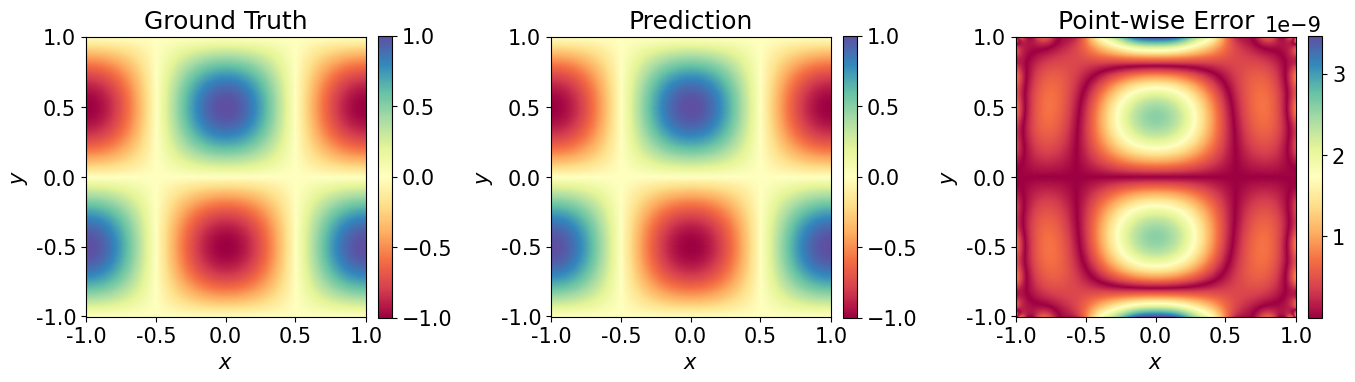

In [22]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 15})
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
folder = r'/home/suarez08/PhD_PINNs/Benchmark_Dominik/Results_Dominik/'
x = test_xs[0]
y = test_xs[1]
Xt, Yt = np.meshgrid(test_xs[0],test_xs[1])
out = model(data).T[0].reshape(249,249).detach().numpy()
u_sol = gt(Xt,Yt)
#out = N_p()._eval(X_r).reshape(100,100)
L0_inf = np.max(abs(out-u_sol))
#Lp_inf = torch.max(abs(poisson_residual(net_s(inp_r),inp_r,omega).reshape(-1)))
L0_mean =np.mean(abs(out-u_sol))
print("pred rel. linf-error = {:e}".format(L0_inf))
print("pred rel. l2-error = {:e}".format(L0_mean))
#print("pde res. linf-error = {:e}".format(Lp_inf))
xl = np.linspace(-1,1, 5)
x_ticks = np.around(xl, 1)
plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="lower")
#plt.clim(-0.3,0.4)
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="lower")
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol), cmap="Spectral", origin="lower")
#plt.clim(np.min(np.abs(out-u_sol)/np.max(np.abs(u_sol))),np.max(np.abs(out-u_sol)/np.max(np.abs(u_sol))))
plt.xticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.yticks(np.linspace(0,len(x), 5, dtype = int),x_ticks)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.colorbar(fraction=0.046, pad=0.04)

plt.gcf().set_size_inches(14,4)
plt.tight_layout()
plt.savefig(folder + 'L_inf_error.png')
#plt.savefig(folder + 'pred_error_MSE.png',bbox_inches='tight')

In [23]:
lam_p-2*lam**2

tensor(-6.1268e-08, grad_fn=<SubBackward0>)